In [1]:
# here we test imagination of models, that is , only relying on generative inference
# we already have the code for the Psychiatry hallucination paper for hallucination

In [1]:
%reload_ext autoreload
%autoreload 2

import socket
import os
if socket.gethostname().startswith('ax'):
    path_prefix = '/mnt/smb/locker/miller-locker/users/Tahereh'
    path_codes = '/mnt/smb/locker/miller-locker/users/Tahereh/Codes/Perceptually_Aligned_Gradients/'
    os.chdir(path_codes)
    import sys
    sys.path.append(path_codes)
    sys.path.append('/mnt/smb/locker/miller-locker/users/Tahereh/Codes/Perceptually_Aligned_Gradients/Illusions')
elif socket.gethostname().startswith('demo'):
    path_prefix = '/home/tahereh/engram/users/Tahereh'
    path_codes = '/home/tahereh/engram/users/Tahereh/Codes/Public_Codes/Generative_Inference/'
    os.chdir(path_codes)
    import sys
    sys.path.append(path_codes)
    
print(os.getcwd())


## Settings of results 
fontsize_text = 25
color_text = 'mediumseagreen'
fontsize_text = 12


resultsdir = os.path.join(path_prefix, 'Research/Results/Generative_Inference')

# get the labels for imagenet
from Stimuli.load_stimuli import labels_imagenet


/home/tahereh/engram/users/Tahereh/Codes/Public_Codes/Generative_Inference
Kernel running on local computer 'demo'.
['tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead shark']


/home/tahereh/anaconda3/envs/robustbenchpy311/lib/python3.11/site-packages/robustness/train.py:24: UserWarning: Could not import amp.
  warnings.warn('Could not import amp.')


image names:  ('self', 'image_name', 'image_original', 'cmap')


In [2]:
import torch

# for face net: 'advrobust_L2_eps_0.50' checkpoint 100
class Args:
    def __init__(self) -> None:
        self.model_arch = 'resnet50' #'resnet50' 'resnext50-32x4d'
        
        self.dataset_model ='imagenet' #'Places365' #'imagenet' # 'imagenetvggface2'#'vggface2' #'imagenet'
        self.model_training ='advrobust_L2_eps_3.00' #'standard' ##'advrobust_L2_eps_0.50' #'advrobust_Linf_eps_4.00' #'advrobust_L2_eps_3.00' #'advrobust_Linf_eps_4.00' #'advrobust_L2_eps_0.50'  'advrobust_L2_eps_3.00' #
        
        self.input_size = 224
        # self.dataset_model =  'vggface2' #'imagenet' # 'imagenetvggface2'#'vggface2' #'imagenet'
        # self.model_training ='advrobust_L2_eps_0.50' ##'advrob
        
        # self.dataset_model =  'imagenetvggface2'#'vggface2' #'imagenet'
        # self.model_training ='advrobust_L2_eps_3.00' ##'advrob
        
        self.epoch_chkpnt = 'madryfull' #'0' #'full' #176 #100#'full' # 160 for vggface IncConfMSE #'full'  98 is the highest for places365
        self.eval_dataset_identifier = 'vggface2_test'
        self.batch_size = 32


args = Args()

if args.dataset_model == 'vggface2':
    # assert args.model_training == 'advrobust_L2_eps_0.50'
    args. norm_mean = torch.tensor([0.5, 0.5, 0.5]).cuda()
    args.norm_std = torch.tensor([0.5, 0.5, 0.5]).cuda()
    args.n_classes = 500
elif 'imagenet' in  args.dataset_model or 'Places365' in args.dataset_model:
    args.norm_mean = torch.tensor([0.485, 0.456, 0.406]).cuda()
    args.norm_std = torch.tensor([0.229, 0.224, 0.225]).cuda()
    args.n_classes = 1000
else:
    raise ValueError(f"Dataset model {args.dataset_model} not supported yet")
          

#'vggface2'  'advrobust_L2_eps_0.50' 'full' 'vggface2_test' 32
# Load the model -----------------------------
model_args = {'model_arch': args.model_arch, 
              'model_training': args.model_training,
              'dataset': args.dataset_model,
              'epoch_chkpnt': args.epoch_chkpnt,
              'input_size': args.input_size,
              'norm_mean': args.norm_mean,
              'norm_std': args.norm_std,
              'n_classes': args.n_classes,
            #   'inference': args.inference
              }

from Models import load_models
model, _ = load_models.load_models(model_args)
model = torch.nn.DataParallel(model).cuda()
_=model.eval()


Kernel running on local computer 'demo'.
['/home/tahereh/anaconda3/envs/robustbenchpy311/lib/python311.zip', '/home/tahereh/anaconda3/envs/robustbenchpy311/lib/python3.11', '/home/tahereh/anaconda3/envs/robustbenchpy311/lib/python3.11/lib-dynload', '', '/home/tahereh/anaconda3/envs/robustbenchpy311/lib/python3.11/site-packages', '/home/tahereh/engram/users/Tahereh/Codes/Github/lucent', '/home/tahereh/anaconda3/envs/robustbenchpy311/lib/python3.11/site-packages/setuptools/_vendor', '/home/tahereh/engram/users/Tahereh/Codes/Public_Codes/Generative_Inference/', '/home/tahereh/engram/users/Tahereh/Codes/Perceptually_Aligned_Gradients']
args is a dictionary
get_dict_hash: dataset: imagenet, model_arch: resnet50
=> loading checkpoint '/home/tahereh/engram/users/Tahereh/Codes/Perceptually_Aligned_Gradients/Training/TrainedModels/madry_robust/imagenet/L2/imagenet_l2_3_0.pt'
=> loaded checkpoint '/home/tahereh/engram/users/Tahereh/Codes/Perceptually_Aligned_Gradients/Training/TrainedModels/madr

In [9]:
## test the generative inference function
from Stimuli.load_stimuli import ImageLoader
from Inference.Generative_infernece import generative_inference

model_config = {'model': model, 'dataset_model': args.dataset_model, **model_args}

# For reverse diffusion:
## pretty print the model_config
inference_config = {'loss_infer': 'ReverseDiffusion',#'IncreaseConfidence',# #'IncreaseConfidence', #'ReverseDiffusion', 
                    'loss_function': 'MSE',#'MSE',# #'CE', #'MSE', 
                    'n_itr':1001, 
                    'eps': 40, #0.5, 
                    'step_size': 5, #3
                    'diffusion_noise_ratio': 0.003,#0.05, 
                    'initial_inference_noise_ratio': 0.3,#0.5, #0.1, 
                    'iterations_to_show': [0, 1, 5, 10, 20, 30, 50, 80, 100, 200,  400,  600, 700, 800,  1000],
                    # 'iterations_to_show': [0, 1, 2, 4, 8, 16, 20, 32, 64, 80, 100, 128, 160, 180, 200, 240, 280, 320, 420, 520, 620, 720, 820, 920,],
                    'top_layer': 'avgpool', #'layer4', #'avgpool', #'all',
                    'inference_normalization': 'off',
                    'recognition_normalization': 'off',
                    'misc_info': {'keep_grads': True,}
                    }

# For increase confidence:
# inference_config = {'loss_infer': 'IncreaseConfidence',# #'IncreaseConfidence', #'ReverseDiffusion', 
#                     'loss_function': 'MSE',#'MSE',# #'CE', #'MSE', 
#                     'n_itr':1001, 
#                     'eps': 40, #0.5, 
#                     'step_size': 5, #3
#                     'diffusion_noise_ratio': 0.1,#0.05, 
#                     'initial_inference_noise_ratio': 0.1,#0.05, #0.1, 
#                     'iterations_to_show': [0, 1, 5, 10, 20, 30, 50, 80, 100, 200,  400,  600, 700, 800,  1000],
#                     # 'iterations_to_show': [0, 1, 2, 4, 8, 16, 20, 32, 64, 80, 100, 128, 160, 180, 200, 240, 280, 320, 420, 520, 620, 720, 820, 920,],
#                     'top_layer': 'all', #'layer4', #'avgpool', #'all',
#                     'inference_normalization': 'off',
#                     'recognition_normalization': 'off',
#                     'misc_info': {'keep_grads': True,}
#                     }


# inference_config = {'loss_infer': 'ReverseDiffusion',# #'IncreaseConfidence', #'ReverseDiffusion', 
#                     'loss_function': 'MSE',#'MSE',# #'CE', #'MSE', 
#                     'n_itr':1001, 
#                     'eps': 400, #0.5, 
#                     'step_size': 2, #3
#                     'diffusion_noise_ratio': 0.03,#0.05, 
#                     'initial_inference_noise_ratio': 0.5,#0.05, #0.1, 
#                     'iterations_to_show': [0, 1, 5, 10, 20, 30, 50, 80, 100, 200,  400,  600, 700, 800,  1000],
#                     # 'iterations_to_show': [0, 1, 2, 4, 8, 16, 20, 32, 64, 80, 100, 128, 160, 180, 200, 240, 280, 320, 420, 520, 620, 720, 820, 920,],
#                     'top_layer': 'all', #'layer4', #'avgpool', #'all',
#                     'inference_normalization': 'off',
#                     'recognition_normalization': 'off',
#                     'misc_info': {'keep_grads': True,
#                                   'smooth_inference': True,
#                                   'smooth_samples': 50,
#                                   'smooth_batch_size': 1,
#                                   'smooth_sigma': 0.25,
#                                   'smooth_multiscale': True}
#                     }
# Testing for the untrained model
# inference_config = {'loss_infer': 'ReverseDiffusion',# #'IncreaseConfidence', #'ReverseDiffusion', 
#                     'loss_function': 'MSE',#'MSE',# #'CE', #'MSE', 
#                     'n_itr':1001, 
#                     'eps': 10, #0.5, 
#                     'step_size': 5, #3
#                     'diffusion_noise_ratio': 0.03,#0.05, 
#                     'initial_inference_noise_ratio': 0.9,#0.05, #0.1, 
#                     'iterations_to_show': [0, 1, 5, 10, 20, 30, 50, 80, 100, 200,  400,  600, 700, 800,  1000],
#                     # 'iterations_to_show': [0, 1, 2, 4, 8, 16, 20, 32, 64, 80, 100, 128, 160, 180, 200, 240, 280, 320, 420, 520, 620, 720, 820, 920,],
#                     'top_layer': 'all', #'layer4', #'avgpool', #'all',
#                     'inference_normalization': 'off',
#                     'recognition_normalization': 'off',
#                     'misc_info': {'keep_grads': False,
#                                   'smooth_inference': True,
#                                   'smooth_samples': 1,
#                                   'smooth_batch_size': 1,
#                                   'smooth_sigma': 1,
#                                   'smooth_multiscale': False}
#                     }


image_name = 'RandomizedPhaseovalGray' #'RandomizedPhaseoval' #'KanizsaRealContours' #'KanizsaSq' 
image, cmap = ImageLoader(args.dataset_model).load_image(image_name)


selected_inferred_patterns, perceived_categories, confidence_list, misc_info_dict = generative_inference(model_config, image, inference_config)
iteration_numbers = inference_config['iterations_to_show']
if inference_config['misc_info']['keep_grads']:
    selected_grad_patterns = misc_info_dict['grad_info']
else:
    selected_grad_patterns = []

Sequential(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): SequentialWithArgs(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1),

/home/tahereh/anaconda3/envs/robustbenchpy311/lib/python3.11/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Gen Inf: loss_infer=ReverseDiffusion, loss_function=MSE, noise_ratio=0.3, diffusion_noise_ratio=0.003, n_itr=1001, eps=40, step_size=5
 model: resnet50-imagenet-resnet50-advrobust_L2_eps_3.00-epochmadryfull-toplayeravgpool


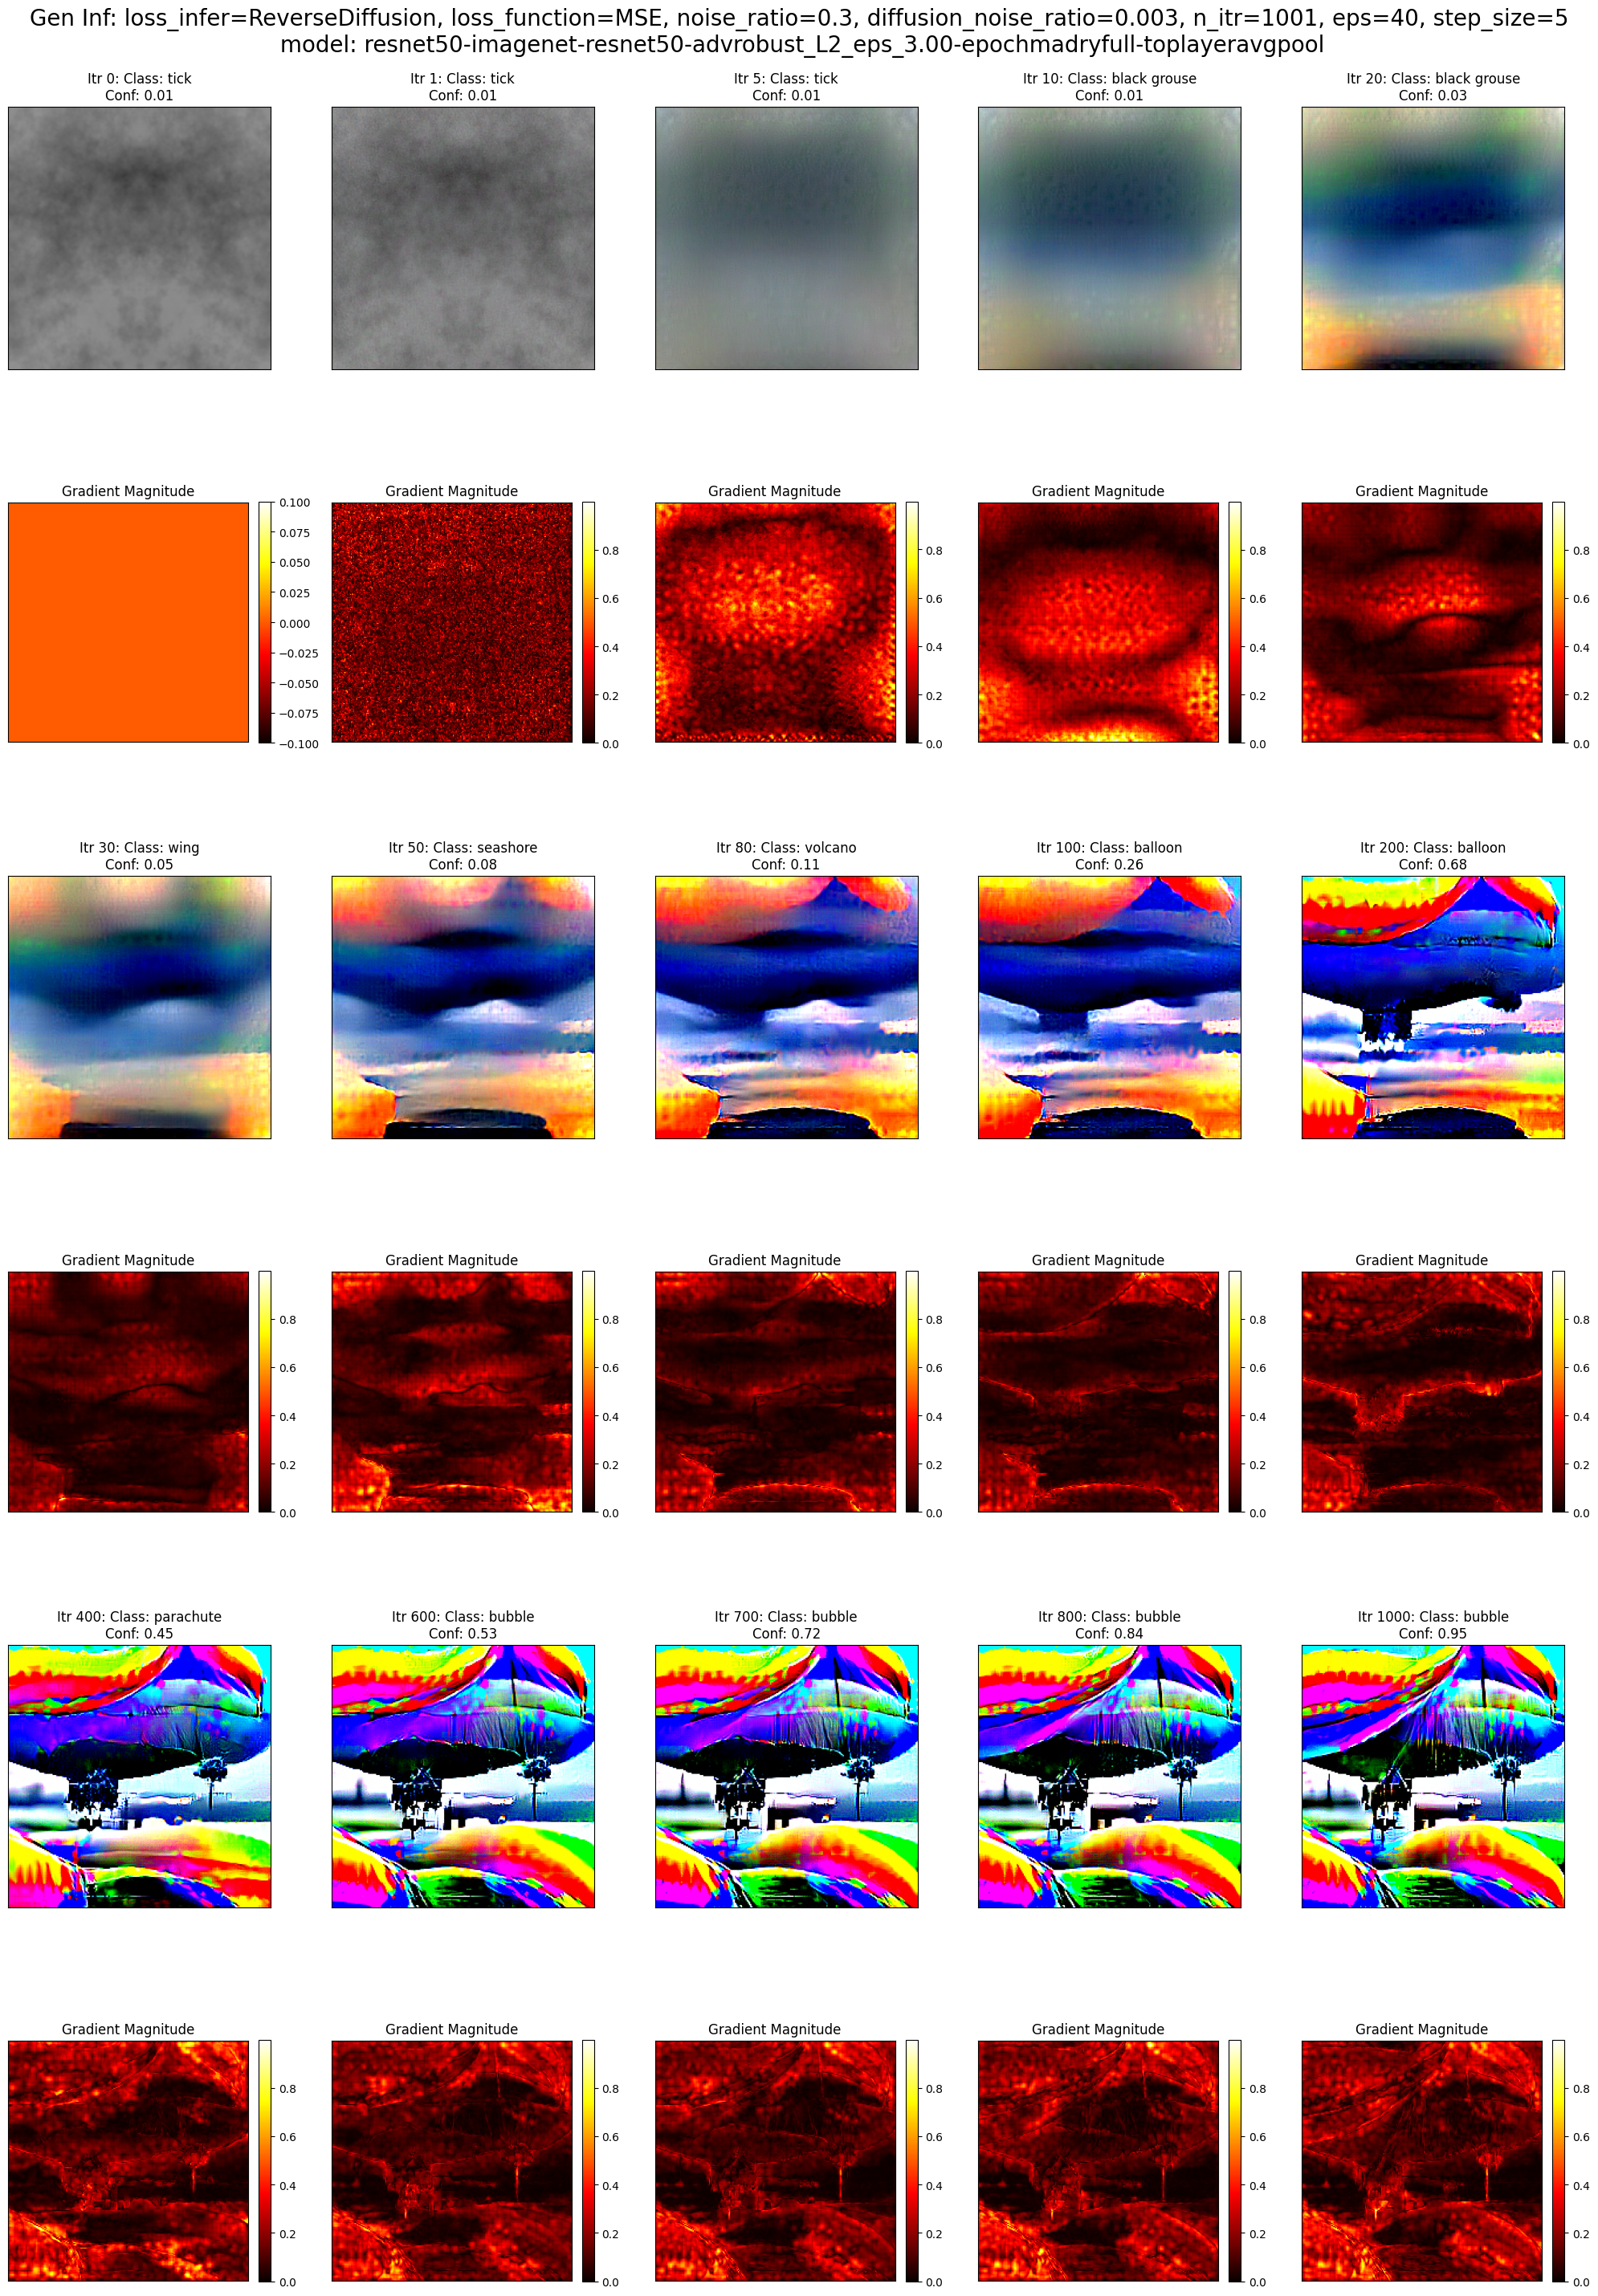

saved at: /home/tahereh/engram/users/Tahereh/Research/Results/Generative_Inference/resnet50_imagenet-advrobust_L2_eps_3.00-madryfull/RandomizedPhaseovalGray_avgpool_geninf_imagenet_resnet50_advrobust_L2_eps_3.00_epochmadryfull_ReverseDiffusion_MSE_noise_ratio0.3_diffusion_noise_ratio0.003_n_itr1001_eps40_step_size5_confitr0_False_with_gradients.pdf


In [10]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch

# show the images and gradients in a grid - now with 2 rows per pattern
n_cols = 5
n_pattern_rows = len(selected_inferred_patterns)//n_cols + (1 if len(selected_inferred_patterns)%n_cols > 0 else 0)
if n_pattern_rows == 0:
    n_pattern_rows = 1
# Double the rows to accommodate gradients below each image
n_total_rows = n_pattern_rows * 2
fig, axes = plt.subplots(n_total_rows, n_cols, figsize=[20, 5*n_pattern_rows * 2])

if model_config['dataset_model'] == 'vggface2':
    norm_mean = torch.tensor([0.5,0.5,0.5]).view(-1, 1, 1).cuda()
    norm_std = torch.tensor([0.5,0.5,0.5]).view(-1, 1, 1).cuda()
elif model_config['dataset_model'] == 'imagenet' or model_config['dataset_model'] == 'imagenetvggface2':
    norm_mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1).cuda()
    norm_std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1).cuda()

for i in range(len(selected_inferred_patterns)):
    # Calculate positions for image and gradient
    row_idx = (i // n_cols) * 2  # Multiply by 2 to skip rows for gradients
    col_idx = i % n_cols
    
    # Get axes for both image and gradient
    if n_pattern_rows == 1:
        ax_img = axes[0] if n_cols == 1 else axes[col_idx]
        ax_grad = axes[1] if n_cols == 1 else axes[n_cols + col_idx]
    else:
        ax_img = axes[row_idx, col_idx]
        ax_grad = axes[row_idx + 1, col_idx]
        
    # Get the image and corresponding gradients
    image_to_compute = selected_inferred_patterns[i].squeeze(0).detach().cpu().numpy().transpose(1,2,0)
    if inference_config['misc_info']['keep_grads']:
        gradients = selected_grad_patterns[i].squeeze(0).detach().cpu().numpy().transpose(1,2,0)
    else:
        gradients = np.zeros_like(image_to_compute)
    
    # Normalize gradients for visualization
    if inference_config['misc_info']['keep_grads']:
        grad_magnitude = np.sqrt(np.sum(gradients**2, axis=2))
        grad_normalized = (grad_magnitude - grad_magnitude.min()) / (grad_magnitude.max() - grad_magnitude.min() + 1e-8)
    else:
        grad_normalized = np.zeros_like(image_to_compute)
        
    
    predicted_emotion = 'N/A'
    confidence_emotion = 0
    first_itr_conf_got_high = 0
    emotion_detected = False
    color_title = 'black'
    
    # Plot image in top subplot
    ax_img.imshow(image_to_compute)
    # Plot gradient heatmap in bottom subplot
    gradient_plot = ax_grad.imshow(grad_normalized, cmap='hot')
    plt.colorbar(gradient_plot, ax=ax_grad, fraction=0.046, pad=0.04)
    
    # Set titles
    if model_config['dataset_model'] == 'imagenet':
        ax_img.set_title(f'Itr {iteration_numbers[i]}: Class: {labels_imagenet[perceived_categories[i]]}\nConf: {confidence_list[i]:.2f}', color=color_title)
    else:
        ax_img.set_title(f'Itr {iteration_numbers[i]}: Class: {perceived_categories[i]}\nConf: {confidence_list[i]:.2f}', color=color_title)
    
    ax_grad.set_title('Gradient Magnitude')
    
    # Remove ticks from both subplots
    ax_img.set_xticks([])
    ax_img.set_yticks([])
    ax_grad.set_xticks([])
    ax_grad.set_yticks([])

title = f'Gen Inf: loss_infer={inference_config["loss_infer"]}, loss_function={inference_config["loss_function"]}, noise_ratio={inference_config["initial_inference_noise_ratio"]}, diffusion_noise_ratio={inference_config["diffusion_noise_ratio"]}, n_itr={inference_config["n_itr"]}, eps={inference_config["eps"]}, step_size={inference_config["step_size"]}\n model: {args.model_arch}-{args.dataset_model}-{args.model_arch}-{args.model_training}-epoch{args.epoch_chkpnt}-toplayer{inference_config["top_layer"]}'
if 'smooth_inference' in inference_config['misc_info']:
    title = title + f'\n smooth_inference={inference_config["misc_info"]["smooth_inference"]}, smooth_samples={inference_config["misc_info"]["smooth_samples"]}, smooth_batch_size={inference_config["misc_info"]["smooth_batch_size"]}, smooth_sigma={inference_config["misc_info"]["smooth_sigma"]}, smooth_multiscale={inference_config["misc_info"]["smooth_multiscale"]}'
print(title)

fig.suptitle(title, fontsize=20)

# Remove empty axes
for i in range(n_total_rows):
    for j in range(n_cols):
        pattern_idx = (i//2) * n_cols + j
        if pattern_idx >= len(selected_inferred_patterns):
            if n_pattern_rows > 1:
                fig.delaxes(axes[i, j])

plt.tight_layout()
plt.show()

# Save fi#gure
figsave_dir = os.path.join(resultsdir, f'{args.model_arch}_{args.dataset_model}-{args.model_training}-{args.epoch_chkpnt}/')
if not os.path.exists(figsave_dir):
    os.makedirs(figsave_dir)

fig_name = f'{image_name}_{inference_config["top_layer"]}_geninf_{model_config["dataset_model"]}_{args.model_arch}_{model_config["model_training"]}_epoch{model_config["epoch_chkpnt"]}_{inference_config["loss_infer"]}_{inference_config["loss_function"]}_noise_ratio{inference_config["initial_inference_noise_ratio"]}_diffusion_noise_ratio{inference_config["diffusion_noise_ratio"]}_n_itr{inference_config["n_itr"]}_eps{inference_config["eps"]}_step_size{inference_config["step_size"]}'
fig_name = fig_name + f'_confitr{first_itr_conf_got_high}_{emotion_detected}_with_gradients'
if 'smooth_inference' in inference_config['misc_info']:
    fig_name = fig_name + f'_smooth_inference={inference_config["misc_info"]["smooth_inference"]}, smooth_multiscale={inference_config["misc_info"]["smooth_multiscale"]}'

instance_counter = 0
while os.path.exists(os.path.join(figsave_dir, fig_name+'.pdf')):
    print('file already exists, adding instance number')
    if 'instance' in fig_name:
        fig_name = fig_name.split('_instance')[0]
    fig_name = fig_name + f'_instance{instance_counter}'
    instance_counter += 1

fig.savefig(os.path.join(figsave_dir, fig_name+'.pdf'), dpi=300, bbox_inches='tight')

print('saved at:', os.path.join(figsave_dir, fig_name+'.pdf'))

# Save results dictionary
dict_results = {
    'model_config': model_config,
    'inference_config': inference_config,
    'selected_inferred_patterns': selected_inferred_patterns,
    'selected_grad_patterns': selected_grad_patterns,
    'perceived_categories': perceived_categories,
    'iteration_numbers': iteration_numbers,
    # 'contrast_list': contrast_list,
    # 'predicted_emotion_list': predicted_emotion_list,
    # 'confidence_emotion_list': confidence_emotion_list
}
np.save(os.path.join(figsave_dir, fig_name+'.npy'), dict_results)

In [11]:
## save a copy of the resulted fig in the resultsdir
path_save_a_copy_significant = os.path.join(resultsdir,'Selected_to_inspect',  fig_name+'.pdf')
fig.savefig(path_save_a_copy_significant, dpi=300, bbox_inches='tight')
print('saved a copy of the resulted fig at:', path_save_a_copy_significant)


saved a copy of the resulted fig at: /home/tahereh/engram/users/Tahereh/Research/Results/Generative_Inference/Selected_to_inspect/RandomizedPhaseovalGray_avgpool_geninf_imagenet_resnet50_advrobust_L2_eps_3.00_epochmadryfull_ReverseDiffusion_MSE_noise_ratio0.3_diffusion_noise_ratio0.003_n_itr1001_eps40_step_size5_confitr0_False_with_gradients.pdf


In [12]:
import imageio
import matplotlib.cm as cm
import numpy as np
import os

# Prepare lists to hold frames
image_frames = []
grad_frames = []

for i in range(len(selected_inferred_patterns)):
    # Get the image and corresponding gradients
    image_to_compute = selected_inferred_patterns[i].squeeze(0).detach().cpu().numpy().transpose(1,2,0)
    gradients = selected_grad_patterns[i].squeeze(0).detach().cpu().numpy().transpose(1,2,0)
    
    # Normalize gradients for visualization
    grad_magnitude = np.sqrt(np.sum(gradients**2, axis=2))
    grad_normalized = (grad_magnitude - grad_magnitude.min()) / (grad_magnitude.max() - grad_magnitude.min() + 1e-8)
    
    # Prepare image frame (clip to [0,1] and convert to uint8)
    img_uint8 = (np.clip(image_to_compute, 0, 1) * 255).astype(np.uint8)
    image_frames.append(img_uint8)
    
    # Prepare gradient frame (convert to RGB heatmap and uint8)
    grad_rgb = cm.hot(grad_normalized)[:, :, :3]  # Drop alpha channel
    grad_uint8 = (grad_rgb * 255).astype(np.uint8)
    grad_frames.append(grad_uint8)

# Save GIFs
gif_dir = figsave_dir  # Use the same directory as your figures
imageio.mimsave(os.path.join(gif_dir, f'{fig_name}_images.gif'), image_frames, duration=0.5)
imageio.mimsave(os.path.join(gif_dir, f'{fig_name}_gradients.gif'), grad_frames, duration=0.5)
print('GIFs saved at:', gif_dir)

GIFs saved at: /home/tahereh/engram/users/Tahereh/Research/Results/Generative_Inference/resnet50_imagenet-advrobust_L2_eps_3.00-madryfull/


### make a whole figure for hallucination: perceptual denoising for each layer in a row

/home/tahereh/anaconda3/envs/robustbenchpy311/lib/python3.11/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


saved at: /home/tahereh/engram/users/Tahereh/Research/Results/Generative_Inference/resnext50-32x4d_imagenet-advrobust_L2_eps_3.00-full/EachLayer_RandomizedPhaseovalGray_layer1_geninf_imagenet_resnext50-32x4d_advrobust_L2_eps_3.00_epochfull_ReverseDiffusion_MSE_noise_ratio0.5_diffusion_noise_ratio0.003_n_itr1001_eps40_step_size5_activations.pdf
saved at: /home/tahereh/engram/users/Tahereh/Research/Results/Generative_Inference/resnext50-32x4d_imagenet-advrobust_L2_eps_3.00-full/EachLayer_RandomizedPhaseovalGray_layer1_geninf_imagenet_resnext50-32x4d_advrobust_L2_eps_3.00_epochfull_ReverseDiffusion_MSE_noise_ratio0.5_diffusion_noise_ratio0.003_n_itr1001_eps40_step_size5_gradients.pdf


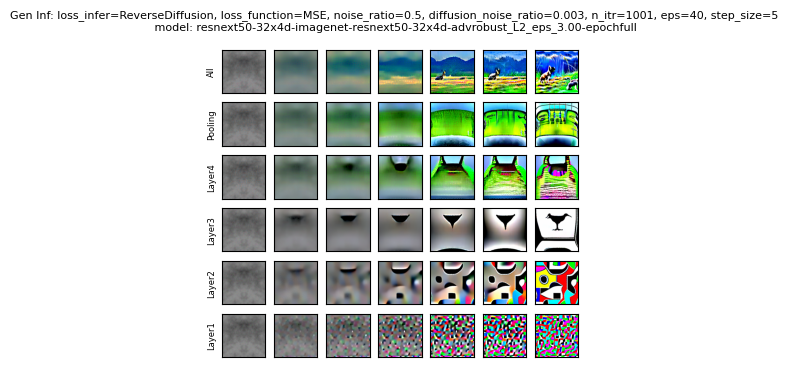

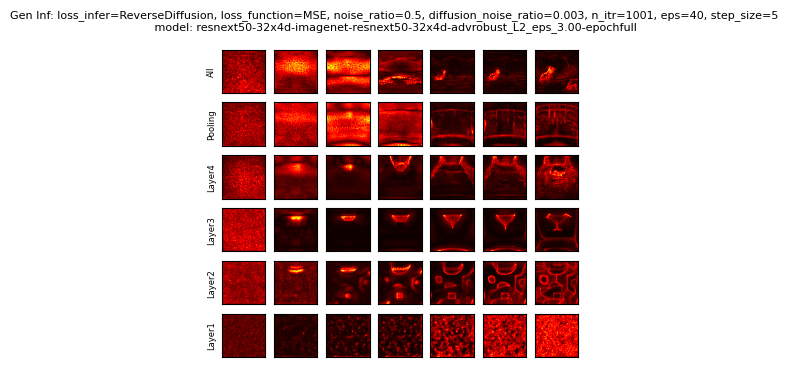

In [85]:
from Stimuli.load_stimuli import ImageLoader
from Inference.Generative_infernece import generative_inference
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
model_config = {'model': model, 'dataset_model': args.dataset_model, **model_args}

# For reverse diffusion:
## pretty print the model_config
inference_config = {'loss_infer': 'ReverseDiffusion',#'IncreaseConfidence',# #'IncreaseConfidence', #'ReverseDiffusion', 
                    'loss_function': 'MSE',#'MSE',# #'CE', #'MSE', 
                    'n_itr':1001, 
                    'eps': 40, #0.5, 
                    'step_size': 5, #3
                    'diffusion_noise_ratio': 0.003,#0.05, 
                    'initial_inference_noise_ratio': 0.5,#0.05, #0.1, 
                    'iterations_to_show': [1, 5, 10, 20, 50, 100, 1000],
                    'top_layer': 'all', #'layer4', #'avgpool', #'all',
                    'inference_normalization': 'off',
                    'recognition_normalization': 'off',
                    'misc_info': {'keep_grads': True,}}

assert inference_config['iterations_to_show'][-1]<inference_config['n_itr'], "last iteration number must be less than n_itr"

image_name = 'RandomizedPhaseovalGray' #'RandomizedPhaseoval' #'KanizsaRealContours' #'KanizsaSq' 
image, cmap = ImageLoader(args.dataset_model).load_image(image_name)

layers = ['all',  'avgpool', 'layer4', 'layer3', 'layer2', 'layer1']
if args.dataset_model == 'imagenet':
    layers = ['all',  'avgpool', 'layer4', 'layer3', 'layer2', 'layer1']
elif args.dataset_model in ['imagenetvggface2', 'vggface2']:
    layers = ['all',  'global_pool', 'layer4', 'layer3', 'layer2', 'layer1']
else:
    raise ValueError(f"Dataset model {args.dataset_model} not supported yet")
layer_label = {
    'all': 'All',
    'avgpool': 'Pooling',
    'global_pool': 'Pooling',
    'layer4': 'Layer4',
    'layer3': 'Layer3',
    'layer2': 'Layer2',
    'layer1': 'Layer1'
}
iteration_numbers = inference_config['iterations_to_show']
fig_activations, axes_activations = plt.subplots(len(layers), len(iteration_numbers), figsize=[4.6, 4])
fig_gradients, axes_gradients = plt.subplots(len(layers), len(iteration_numbers), figsize=[4.6, 4])

for i, top_layer in enumerate(layers):
    
    inference_config['top_layer'] = top_layer
    selected_inferred_patterns, perceived_categories, confidence_list, misc_info_dict = generative_inference(model_config, image, inference_config)
    
    
    if inference_config['misc_info']['keep_grads']:
        selected_grad_patterns = misc_info_dict['grad_info']
    else:
        selected_grad_patterns = []
    for j, iteration_number in enumerate(iteration_numbers):
        ax_img = axes_activations[i, j]
        ax_img.imshow(selected_inferred_patterns[j].squeeze(0).detach().cpu().numpy().transpose(1,2,0))
        ax_grad = axes_gradients[i, j]
        
        
        # Normalize gradients for visualization
        gradients = selected_grad_patterns[j].squeeze(0).detach().cpu().numpy().transpose(1,2,0)
        grad_magnitude = np.sqrt(np.sum(gradients**2, axis=2))
        grad_normalized = (grad_magnitude - grad_magnitude.min()) / (grad_magnitude.max() - grad_magnitude.min() + 1e-8)
        
        ax_grad.imshow(grad_normalized, cmap='hot')
        if j == 0:
            ax_grad.set_ylabel(layer_label[top_layer], fontsize=6)
            ax_img.set_ylabel(layer_label[top_layer], fontsize=6)
        
        ax_img.set_xticks([])
        ax_img.set_yticks([])
        ax_grad.set_xticks([])
        ax_grad.set_yticks([])
        
fig_activations.suptitle(f'Gen Inf: loss_infer={inference_config["loss_infer"]}, loss_function={inference_config["loss_function"]}, noise_ratio={inference_config["initial_inference_noise_ratio"]}, diffusion_noise_ratio={inference_config["diffusion_noise_ratio"]}, n_itr={inference_config["n_itr"]}, eps={inference_config["eps"]}, step_size={inference_config["step_size"]}\n model: {args.model_arch}-{args.dataset_model}-{args.model_arch}-{args.model_training}-epoch{args.epoch_chkpnt}', fontsize=8)
fig_gradients.suptitle(f'Gen Inf: loss_infer={inference_config["loss_infer"]}, loss_function={inference_config["loss_function"]}, noise_ratio={inference_config["initial_inference_noise_ratio"]}, diffusion_noise_ratio={inference_config["diffusion_noise_ratio"]}, n_itr={inference_config["n_itr"]}, eps={inference_config["eps"]}, step_size={inference_config["step_size"]}\n model: {args.model_arch}-{args.dataset_model}-{args.model_arch}-{args.model_training}-epoch{args.epoch_chkpnt}', fontsize=8)


figsave_dir = os.path.join(resultsdir, f'{args.model_arch}_{args.dataset_model}-{args.model_training}-{args.epoch_chkpnt}/')
if not os.path.exists(figsave_dir):
    os.makedirs(figsave_dir)

fig_name = f'EachLayer_{image_name}_{inference_config["top_layer"]}_geninf_{model_config["dataset_model"]}_{args.model_arch}_{model_config["model_training"]}_epoch{model_config["epoch_chkpnt"]}_{inference_config["loss_infer"]}_{inference_config["loss_function"]}_noise_ratio{inference_config["initial_inference_noise_ratio"]}_diffusion_noise_ratio{inference_config["diffusion_noise_ratio"]}_n_itr{inference_config["n_itr"]}_eps{inference_config["eps"]}_step_size{inference_config["step_size"]}'


instance_counter = 0
while os.path.exists(os.path.join(figsave_dir, fig_name+'.pdf')):
    print('file already exists, adding instance number')
    if 'instance' in fig_name:  
        fig_name = fig_name.split('_instance')[0]
    fig_name = fig_name + f'_instance{instance_counter}'
    instance_counter += 1

fig_activations.savefig(os.path.join(figsave_dir, fig_name+'_activations.pdf'), dpi=300, bbox_inches='tight')
fig_gradients.savefig(os.path.join(figsave_dir, fig_name+'_gradients.pdf'), dpi=300, bbox_inches='tight')

print(f"saved at: {os.path.join(figsave_dir, fig_name + '_activations.pdf')}")
print(f"saved at: {os.path.join(figsave_dir, fig_name + '_gradients.pdf')}")


In [86]:
path_save_a_copy_significant = os.path.join(resultsdir,'Selected_to_inspect')

fig_activations.savefig(os.path.join(path_save_a_copy_significant, fig_name+'_activations.pdf'), dpi=300, bbox_inches='tight')
fig_gradients.savefig(os.path.join(path_save_a_copy_significant, fig_name+'_gradients.pdf'), dpi=300, bbox_inches='tight')

print(f"saved a copy of the resulted fig at: {path_save_a_copy_significant}")

saved a copy of the resulted fig at: /home/tahereh/engram/users/Tahereh/Research/Results/Generative_Inference/Selected_to_inspect


### make a whole figure for hallucination: increase confidence for different noise ratios in a row

/home/tahereh/anaconda3/envs/robustbenchpy311/lib/python3.11/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


saved at: /home/tahereh/engram/users/Tahereh/Research/Results/Generative_Inference/resnext50-32x4d_imagenet-advrobust_L2_eps_3.00-full/EachNoiseRun_RandomizedPhaseovalGray_all_geninf_imagenet_resnext50-32x4d_advrobust_L2_eps_3.00_epochfull_IncreaseConfidence_MSE_noise_ratio0.1_diffusion_noise_ratio0.1_n_itr1001_eps40_step_size5_activations.pdf
saved at: /home/tahereh/engram/users/Tahereh/Research/Results/Generative_Inference/resnext50-32x4d_imagenet-advrobust_L2_eps_3.00-full/EachNoiseRun_RandomizedPhaseovalGray_all_geninf_imagenet_resnext50-32x4d_advrobust_L2_eps_3.00_epochfull_IncreaseConfidence_MSE_noise_ratio0.1_diffusion_noise_ratio0.1_n_itr1001_eps40_step_size5_gradients.pdf


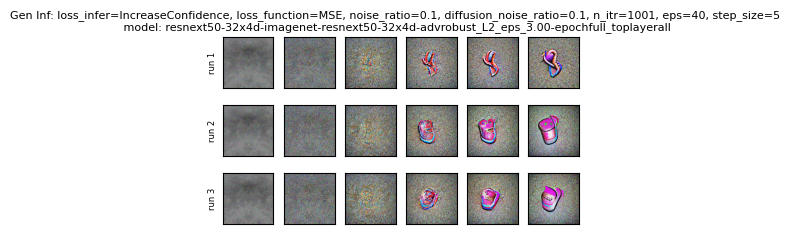

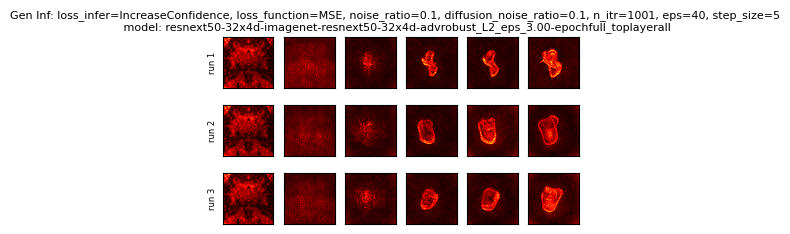

In [87]:
from Stimuli.load_stimuli import ImageLoader
from Inference.Generative_infernece import generative_inference
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
model_config = {'model': model, 'dataset_model': args.dataset_model, **model_args}

# For increase confidence:
inference_config = {'loss_infer': 'IncreaseConfidence',# #'IncreaseConfidence', #'ReverseDiffusion', 
                    'loss_function': 'MSE',#'MSE',# #'CE', #'MSE', 
                    'n_itr':1001, 
                    'eps': 40, #0.5, 
                    'step_size': 5, #3
                    'diffusion_noise_ratio': 0.1,#0.05, 
                    'initial_inference_noise_ratio': 0.1,#0.05, #0.1, 
                    'iterations_to_show': [1, 5, 20,  50, 100, 1000],
                    'top_layer': 'all', #'layer4', #'avgpool', #'all',
                    'inference_normalization': 'off',
                    'recognition_normalization': 'off',
                    'misc_info': {'keep_grads': True,}
                    }

assert inference_config['iterations_to_show'][-1]<inference_config['n_itr'], "last iteration number must be less than n_itr"

image_name = 'RandomizedPhaseovalGray' #'RandomizedPhaseoval' #'KanizsaRealContours' #'KanizsaSq' 
image, cmap = ImageLoader(args.dataset_model).load_image(image_name)

n_iterations_noise = 3
iteration_numbers = inference_config['iterations_to_show']
fig_activations, axes_activations = plt.subplots(n_iterations_noise, len(iteration_numbers), figsize=[4.6, 2.5])
fig_gradients, axes_gradients = plt.subplots(n_iterations_noise, len(iteration_numbers), figsize=[4.6, 2.5])

for i in range(n_iterations_noise):
    
    selected_inferred_patterns, perceived_categories, confidence_list, misc_info_dict = generative_inference(model_config, image, inference_config)
    
    
    if inference_config['misc_info']['keep_grads']:
        selected_grad_patterns = misc_info_dict['grad_info']
    else:
        selected_grad_patterns = []
    for j, iteration_number in enumerate(iteration_numbers):
        ax_img = axes_activations[i, j]
        ax_img.imshow(selected_inferred_patterns[j].squeeze(0).detach().cpu().numpy().transpose(1,2,0))
        ax_grad = axes_gradients[i, j]
        
        
        # Normalize gradients for visualization
        gradients = selected_grad_patterns[j].squeeze(0).detach().cpu().numpy().transpose(1,2,0)
        grad_magnitude = np.sqrt(np.sum(gradients**2, axis=2))
        grad_normalized = (grad_magnitude - grad_magnitude.min()) / (grad_magnitude.max() - grad_magnitude.min() + 1e-8)
        
        ax_grad.imshow(grad_normalized, cmap='hot')
        if j == 0:
            ax_grad.set_ylabel(f'run {i+1}', fontsize=6)
            ax_img.set_ylabel(f'run {i+1}', fontsize=6)
        
        ax_img.set_xticks([])
        ax_img.set_yticks([])
        ax_grad.set_xticks([])
        ax_grad.set_yticks([])
        
fig_activations.suptitle(f'Gen Inf: loss_infer={inference_config["loss_infer"]}, loss_function={inference_config["loss_function"]}, noise_ratio={inference_config["initial_inference_noise_ratio"]}, diffusion_noise_ratio={inference_config["diffusion_noise_ratio"]}, n_itr={inference_config["n_itr"]}, eps={inference_config["eps"]}, step_size={inference_config["step_size"]}\n model: {args.model_arch}-{args.dataset_model}-{args.model_arch}-{args.model_training}-epoch{args.epoch_chkpnt}_toplayer{inference_config["top_layer"]}', fontsize=8)
fig_gradients.suptitle(f'Gen Inf: loss_infer={inference_config["loss_infer"]}, loss_function={inference_config["loss_function"]}, noise_ratio={inference_config["initial_inference_noise_ratio"]}, diffusion_noise_ratio={inference_config["diffusion_noise_ratio"]}, n_itr={inference_config["n_itr"]}, eps={inference_config["eps"]}, step_size={inference_config["step_size"]}\n model: {args.model_arch}-{args.dataset_model}-{args.model_arch}-{args.model_training}-epoch{args.epoch_chkpnt}_toplayer{inference_config["top_layer"]}', fontsize=8)


figsave_dir = os.path.join(resultsdir, f'{args.model_arch}_{args.dataset_model}-{args.model_training}-{args.epoch_chkpnt}/')
if not os.path.exists(figsave_dir):
    os.makedirs(figsave_dir)

fig_name = f'EachNoiseRun_{image_name}_{inference_config["top_layer"]}_geninf_{model_config["dataset_model"]}_{args.model_arch}_{model_config["model_training"]}_epoch{model_config["epoch_chkpnt"]}_{inference_config["loss_infer"]}_{inference_config["loss_function"]}_noise_ratio{inference_config["initial_inference_noise_ratio"]}_diffusion_noise_ratio{inference_config["diffusion_noise_ratio"]}_n_itr{inference_config["n_itr"]}_eps{inference_config["eps"]}_step_size{inference_config["step_size"]}'


instance_counter = 0
while os.path.exists(os.path.join(figsave_dir, fig_name+'.pdf')):
    print('file already exists, adding instance number')
    if 'instance' in fig_name:  
        fig_name = fig_name.split('_instance')[0]
    fig_name = fig_name + f'_instance{instance_counter}'
    instance_counter += 1
    print('adding instance number:', instance_counter)

fig_activations.savefig(os.path.join(figsave_dir, fig_name+'_activations.pdf'), dpi=300, bbox_inches='tight')
fig_gradients.savefig(os.path.join(figsave_dir, fig_name+'_gradients.pdf'), dpi=300, bbox_inches='tight')

print(f"saved at: {os.path.join(figsave_dir, fig_name + '_activations.pdf')}")
print(f"saved at: {os.path.join(figsave_dir, fig_name + '_gradients.pdf')}")


In [81]:
path_save_a_copy_significant = os.path.join(resultsdir,'Selected_to_inspect')

fig_activations.savefig(os.path.join(path_save_a_copy_significant, fig_name+'_activations.pdf'), dpi=300, bbox_inches='tight')
fig_gradients.savefig(os.path.join(path_save_a_copy_significant, fig_name+'_gradients.pdf'), dpi=300, bbox_inches='tight')

print(f"saved a copy of the resulted fig at: {path_save_a_copy_significant}")

saved a copy of the resulted fig at: /home/tahereh/engram/users/Tahereh/Research/Results/Generative_Inference/Selected_to_inspect
